In [1]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
from yellowbrick.cluster import KElbowVisualizer


In [2]:
df=pd.read_csv(r"skincare_preprocessed.csv")

In [3]:
# Step 1: TF-IDF Vectorization on 'title'
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Product_new'])

In [4]:
tfidf_matrix.shape

(13752, 6348)

In [5]:
# Step 2: Normalize numerical features ('price', 'rating')
scaler = StandardScaler()
numeric_features = scaler.fit_transform(df[['Price', 'Rating']])

In [6]:
numeric_features.shape

(13752, 2)

In [7]:
df['Product Type'].value_counts()

Product Type
Face Scrub     1199
Body Wash      1171
body lotion    1137
face Pack      1124
face toner     1120
Face Creame    1118
sunscreen      1110
moisturizer    1098
Face Gel       1072
Face Wash      1053
Face Serum     1013
Face wipes      982
Dtan Pack       555
Name: count, dtype: int64

In [8]:
# Step 3: Encode categorical feature ('product_type')
encoder = OneHotEncoder()
categorical_features = encoder.fit_transform(df[['Product Type']])

In [9]:
categorical_features.shape

(13752, 13)

In [10]:
# Step 4: Combine all features into a single feature matrix
combined_features = hstack([tfidf_matrix, numeric_features, categorical_features])

In [11]:
combined_features.shape

(13752, 6363)

In [14]:
# Step 5: Dimensionality Reduction using PCA
pca = PCA(n_components=500)  # Reduce to 50 dimensions (90.6% variance explained)
reduced_features = pca.fit_transform(combined_features.toarray())


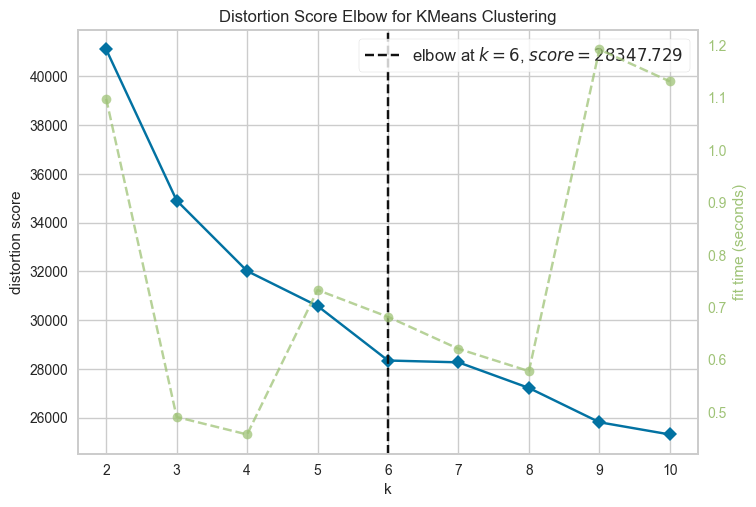

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
# Define no of clusters
kelbow = KElbowVisualizer(KMeans(),k=10)
kelbow.fit(reduced_features)
kelbow.show()

In [ ]:
# Step 6: Clustering with KMeans
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_features)

# Add cluster labels to the DataFrame
df['Cluster'] = clusters


In [ ]:

# Enhanced Recommendation System Function with Clustering
def recommend_products_with_clustering(product_title, num_recommendations=10):
    try:
        # Find the closest match for the product title using fuzzy matching
        #closest_match = process.extractOne(product_title, df['Product_new'])[0]
        #closest_match=product_title
        product_idx = df[df['Product_new'] == product_title].index[0]
        
        # Find the cluster of the queried product
        product_cluster = df.loc[product_idx, 'Cluster']
        
        # Filter products in the same cluster
        cluster_products = df[df['Cluster'] == product_cluster]
        
        # Compute cosine similarity within the cluster
        cluster_features = reduced_features[df['Cluster'] == product_cluster]
        query_features = reduced_features[product_idx].reshape(1, -1)
        cluster_sim_scores = cosine_similarity(query_features, cluster_features)
        
        # Rank products within the cluster by similarity
        sim_scores = list(enumerate(cluster_sim_scores[0]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Get the top N recommendations (excluding the queried product)
        recommended_indices = [cluster_products.index[idx] for idx, score in sim_scores if idx != product_idx][:num_recommendations]
        
        # Return the recommended products
        return #df.loc[recommended_indices]
    except IndexError:
        return "Product title not found in the dataset."



In [ ]:
# Test the recommendation system
product_to_search = "Fruit Brightening Brightens  Soften Skin 100 soap freeMen  Women Face Wash"
recommended_products = recommend_products_with_clustering(product_to_search)

[(0, 1.0), (256, 0.854020913097238), (48, 0.830300627812526), (918, 0.825752175069083), (178, 0.8196475932507103), (677, 0.8173648066746839), (267, 0.8153134982253212), (38, 0.8104506960886053), (568, 0.8093510593066987), (819, 0.8075851539606376), (198, 0.8059211491952997), (835, 0.800634859377056), (699, 0.7991323024001875), (396, 0.7944176407407353), (878, 0.7875542994137841), (934, 0.7834882101864571), (764, 0.78190596978629), (697, 0.7817720169849558), (25, 0.7799350558412286), (434, 0.7785732312128615), (926, 0.7784051790091768), (572, 0.7768487893550983), (887, 0.7760266601977857), (244, 0.7754463223295391), (570, 0.7754099731334452), (189, 0.7740849581849947), (744, 0.7737865867062614), (463, 0.7732259285475737), (284, 0.7720779108915459), (477, 0.769851604618331), (71, 0.7690064317596457), (661, 0.7683775387720295), (181, 0.7681587934262604), (751, 0.7672676212377345), (951, 0.7661771322612536), (680, 0.7661009531365476), (232, 0.7634859319489313), (851, 0.7629825064345018), (

In [18]:
pca.explained_variance_.sum()

3.5342819390654885

In [19]:
pca.explained_variance_ratio_.sum()

0.9060733516853876